# Image Captioning:

Image captioning is an AI task that takes an image as input and outputs a textual description of its content.

It combines two major fields:
- Computer Vision → to understand objects, scenes, and actions in the image
- Natural Language Processing (NLP) → to generate grammatically correct and meaningful captions

#### Dataset:

- Data - [Mini COCO2014 Dataset for Image Captioning](https://www.kaggle.com/datasets/nagasai524/mini-coco2014-dataset-for-image-captioning)

#### Architechute:

- Image Encoder - Vision Transformers(ViT)

- Language Decoder - Transformers


#### Evaluation metric

- Accuracy
- BLEU

In [1]:
# Import required packages. 
import os
import json

# Set environment variable.
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
#os.environ["TF_DISABLE_CUBLASLT"] = "1"
#os.environ["PTXAS_OPTIONS"] = "--maxrregcount=64"

In [2]:
# Import required packages.
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras
import keras_hub
from keras._tf_keras.keras import layers
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

2025-08-15 11:55:41.146243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755239141.163367   16127 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755239141.168392   16127 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755239141.184116   16127 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755239141.184151   16127 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755239141.184154   16127 computation_placer.cc:177] computation placer alr

In [3]:
# For efficient memory usage
keras.mixed_precision.set_global_policy("mixed_float16")
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/warkid/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
seed_value = 777
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [6]:
# Set File Paths to data
IMG_DIR= os.getcwd() + "/data/images"
CAPTION_FILE = os.getcwd() + "/data/captions.json"

# Set Hyperparameters
IMG_SIZE = (224, 224)
MAX_LEN = 32
VOCAB_SIZE = 10_000
EMBED_DIM = 256
INTERMEDIATE_DIM = 512
NUM_HEADS = 8
DROPOUT = 0.5
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
EPOCHS = 5

In [7]:
# Pre-processing setp to create image path and caption pair dataset
def load_data():
    with open(CAPTION_FILE, 'r') as f:
        captions_data = json.load(f)

    image_id_to_caption = {}
    for data in captions_data:
        img_id = data["image_id"]
        caption = data["caption"]
        if img_id not in image_id_to_caption:
            image_id_to_caption[img_id] = []
        image_id_to_caption[img_id].append(caption)

    image_caption_pairs = []
    for img_id, captions in image_id_to_caption.items():
        filename = f"COCO_train2014_{img_id:012d}.jpg"
        img_path = os.path.join(IMG_DIR, filename)
        for caption in captions:
            image_caption_pairs.append((img_path, caption))
    
    return image_caption_pairs

In [8]:
# Load image_path and caption dataset and split between training(80%) and validation dataset(20%)
image_paths, captions = zip(*load_data())
dataset = tf.data.Dataset.from_tensor_slices((list(image_paths), list(captions)))
dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=False)
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)
print(f"Total data: {len(dataset)}")
print(f"Number of Training data: {len(train_ds)}")
print(f"Number of Validation data: {len(val_ds)}")

I0000 00:00:1755239156.271368   16127 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1755239156.272351   16127 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Total data: 93950
Number of Training data: 75160
Number of Validation data: 18790


In [9]:
# Create vocabulary using WordPieceTokenizer 
def train_word_piece(train_ds, vocab_size, reserved_tokens):
    word_piece_ds = train_ds.map(lambda _, caption: caption)
    vocab = keras_hub.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [13]:
# Train tokenizer trained with training dataset
reserved_tokens = ["[PAD]", "[UNK]", "[START]", f"[END]"]
vocab = train_word_piece(train_ds, VOCAB_SIZE, reserved_tokens)
tokenizer = keras_hub.tokenizers.WordPieceTokenizer(
    vocabulary=vocab, lowercase=False, special_tokens=reserved_tokens, special_tokens_in_strings=True
)

In [15]:
# Create folder to store the tokenizer data
os.makedirs("tokenizer", exist_ok=True)
vocab = tokenizer.get_vocabulary()
with open("tokenizer/vocab.txt", "w", encoding="utf-8") as f:
    for token in vocab:
        f.write(token + "\n")

with open("tokenizer/tokenizer_meta.json", "w") as f:
    json.dump({"max_len": MAX_LEN, "max_tokens": len(vocab)}, f)

In [16]:
# Pre-process Image and Caption
def preprocess_image_caption(image_path, caption):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32) / 255.0
    start_end_packer = keras_hub.layers.StartEndPacker(
        sequence_length=MAX_LEN + 1,
        start_value=tokenizer.token_to_id("[START]"),
        end_value=tokenizer.token_to_id(f"[END]"),
        pad_value=tokenizer.token_to_id("[PAD]"),
    )
    cap_tokens = tokenizer(caption)
    cap_tokens = start_end_packer(cap_tokens)
    return img, cap_tokens

In [17]:
# Load pre-processed data
train_ds = train_ds.map(preprocess_image_caption, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess_image_caption, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [18]:
# Create model architecture (ViT + Transformer decoder)
# Encoder (ViT)
vit_backbone = keras_hub.models.Backbone.from_preset("vit_base_patch16_224_imagenet")
vit_backbone.trainable = False

image_input = keras.Input(shape=(224, 224, 3), name="image")
encoder_outputs = vit_backbone(image_input)
encoder_proj = layers.Dense(256, activation="relu")(encoder_outputs)

# Decoder (Transformer)
caption_input = keras.Input(shape=(None,), dtype=tf.int32, name="caption")
x = keras_hub.layers.TokenAndPositionEmbedding(vocabulary_size=VOCAB_SIZE, sequence_length=MAX_LEN, embedding_dim=EMBED_DIM)(caption_input)
x = keras_hub.layers.TransformerDecoder(intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS)(decoder_sequence=x, encoder_sequence=encoder_proj)
x = layers.Dropout(DROPOUT)(x)
output = layers.Dense(len(vocab), activation="softmax")(x)

model = keras.Model(inputs=[image_input, caption_input], outputs=output)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["sparse_categorical_accuracy"],
    #jit_compile=False
    )

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vi_t_backbone       │ (None, 197, 768)  │ 85,798,656 │ image[0][0]       │
│ (ViTBackbone)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, None, 256) │  2,568,192 │ caption[0][0]     │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 197, 256)  │    196,864 │ vi_t_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decoder │ (None, None, 256) │    790,784 │ token_and_positi… │
│ (TransformerDecode… │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, None, 256) │          0 │ transformer_deco… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None,      │    981,740 │ dropout_14[0][0]  │
│                     │ 3820)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 90,336,236 (344.61 MB)

 Trainable params: 4,537,580 (17.31 MB)

 Non-trainable params: 85,798,656 (327.30 MB)

In [19]:
class CorpusBLEUCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_ds, tokenizer, pad_token_id=0, start_token_id=2, end_token_id=3, max_len=64):
        super().__init__()
        self.val_ds = val_ds
        self.tokenizer = tokenizer
        self.pad_token_id = pad_token_id
        self.start_token_id = start_token_id
        self.end_token_id = end_token_id
        self.max_len = max_len
        self.smooth_fn = SmoothingFunction().method1

    def strip_padding(self, seq_ids):
        return [id_ for id_ in seq_ids if id_ != self.pad_token_id]
    
    def greedy_decode(self, encoder_input):
        batch_size = tf.shape(encoder_input)[0]
        decoder_input = tf.fill([batch_size, 1], self.start_token_id) 

        finished = tf.zeros([batch_size], dtype=tf.bool)

        for _ in range(self.max_len):
            
            preds = self.model([encoder_input, decoder_input], training=False)
            next_token_logits = preds[:, -1, :]
            next_token = tf.argmax(next_token_logits, axis=-1, output_type=tf.int32)

            decoder_input = tf.concat([decoder_input, tf.expand_dims(next_token, axis=1)], axis=1)

            finished = tf.logical_or(finished, tf.equal(next_token, self.end_token_id))

            if tf.reduce_all(finished):
                break

        return decoder_input[:, 1:]

    def on_epoch_end(self, epoch, logs=None):
        predictions = []
        references = []

        for batch_x, batch_y in self.val_ds:

            y_pred_ids = self.greedy_decode(batch_x).numpy()
            batch_y = batch_y.numpy()

            for pred_ids, ref_ids in zip(y_pred_ids, batch_y):
                pred_tokens = self.strip_padding(pred_ids)
                ref_tokens = self.strip_padding(ref_ids)

                predictions.append(pred_tokens)
                references.append([ref_tokens])

        bleu1 = corpus_bleu(references, predictions, weights=(1, 0, 0, 0), smoothing_function=self.smooth_fn)
        bleu2 = corpus_bleu(references, predictions, weights=(0.5, 0.5, 0, 0), smoothing_function=self.smooth_fn)
        bleu3 = corpus_bleu(references, predictions, weights=(1/3, 1/3, 1/3, 0), smoothing_function=self.smooth_fn)
        bleu4 = corpus_bleu(references, predictions, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=self.smooth_fn)

        logs["val_bleu1"] = bleu1
        logs["val_bleu2"] = bleu2
        logs["val_bleu3"] = bleu3
        logs["val_bleu4"] = bleu4

        print(f"\nEpoch {epoch+1} — BLEU-1: {bleu1:.4f}, BLEU-4: {bleu4:.4f}")

In [20]:
# Create folder to store the model checkpoints
os.makedirs("checkpoints", exist_ok=True)
checkpoint = keras.callbacks.ModelCheckpoint(
    "checkpoints/best_model.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)
bleu_cb = CorpusBLEUCallback(val_ds.take(1), tokenizer) # BLEU score is calculated for N * BATCH_SIZE samples.

## Training:

In [21]:
# Train
history = model.fit(
            train_ds.map(lambda img, cap: ((img, cap[:, :-1]), cap[:, 1:])),
            validation_data=val_ds.map(lambda img, cap: ((img, cap[:, :-1]), cap[:, 1:])),
            epochs=EPOCHS,
            callbacks=[checkpoint, bleu_cb]
        )

Epoch 1/5


I0000 00:00:1755239333.430725   16496 service.cc:152] XLA service 0x7e0398004d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755239333.430812   16496 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
I0000 00:00:1755239336.716030   16496 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755239363.487508   16496 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2349/2349 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 1.6541 - sparse_categorical_accuracy: 0.7276
Epoch 1 — BLEU-1: 0.3678, BLEU-4: 0.0870
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 395s 151ms/step - loss: 1.6539 - sparse_categorical_accuracy: 0.7276 - val_loss: 1.2861 - val_sparse_categorical_accuracy: 0.7543 - val_bleu1: 0.3678 - val_bleu2: 0.2397 - val_bleu3: 0.1345 - val_bleu4: 0.0870
Epoch 2/5
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 1.1968 - sparse_categorical_accuracy: 0.7676
Epoch 2 — BLEU-1: 0.3758, BLEU-4: 0.0955
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 315s 134ms/step - loss: 1.1968 - sparse_categorical_accuracy: 0.7676 - val_loss: 1.2160 - val_sparse_categorical_accuracy: 0.7614 - val_bleu1: 0.3758 - val_bleu2: 0.2492 - val_bleu3: 0.1462 - val_bleu4: 0.0955
Epoch 3/5
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.1238 - sparse_categorical_accuracy: 0.7746
Epoch 3 — BLEU-1: 0.3592, BLEU-4: 0.0792
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 326s 139ms/step - loss: 1.1237 - sparse_categorica

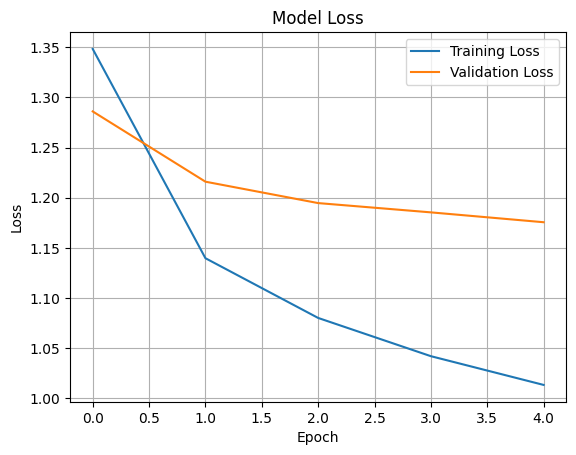

In [23]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

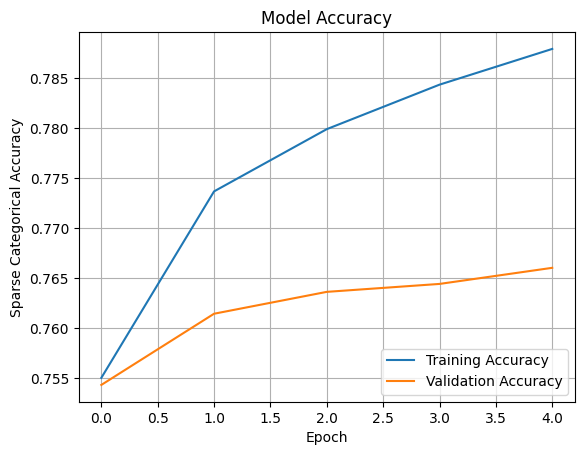

In [24]:
# Plot training & validation sparse accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

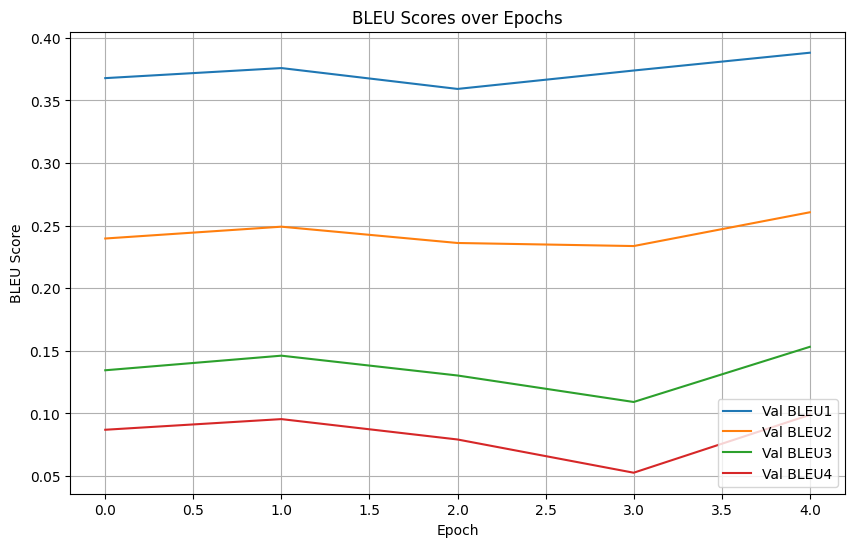

In [25]:
# Plot BLEU-1 to BLEU-4 scores
metrics = ['bleu1', 'bleu2', 'bleu3', 'bleu4']

plt.figure(figsize=(10, 6))

for metric in metrics:
    #plt.plot(history.history[metric], label=f'Train {metric.upper()}')
    plt.plot(history.history[f'val_{metric}'], label=f'Val {metric.upper()}')

plt.title('BLEU Scores over Epochs')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [26]:
# Create folder to store the model training results
os.makedirs("results", exist_ok=True)
df = pd.DataFrame(history.history)
df.to_csv("results/training_history.csv", index=False)

## Prediction:

In [27]:
MODEL_PATH = "checkpoints/best_model.keras"
VOCAB_FILE = "tokenizer/vocab.txt"

In [28]:
tokenizer_ =  keras_hub.tokenizers.WordPieceTokenizer(vocabulary="tokenizer/vocab.txt", lowercase=False)
id_to_token = {i: t for i, t in enumerate(tokenizer_.get_vocabulary())}

In [29]:
def preprocess_image_from_path(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

In [30]:
model_ = keras.models.load_model(MODEL_PATH, compile=False)

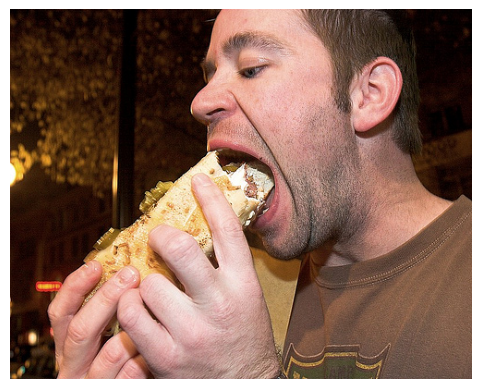

Generated caption: A man is eating a sandwich in his hand .


In [31]:
def generate_caption_greedy(image_path, model, tokenizer, max_len=MAX_LEN):
    start_id = 2
    end_id = 3
    img = preprocess_image_from_path(image_path)
    img = tf.expand_dims(img, 0)

    decoded = [start_id]
    for i in range(max_len - 1):
        dec_input = tf.expand_dims(tf.constant(decoded, dtype=tf.int32), 0)
        preds = model([img, dec_input], training=False)
        logits = preds[0, -1, :]
        next_id = int(tf.argmax(logits).numpy())
        decoded.append(next_id)
        if (end_id is not None) and (next_id == end_id):
            break

    token_ids = decoded[1:]
    words = []
    for tid in token_ids:
        if tid == 0:
            continue
        tok = id_to_token.get(tid, "")
        if end_id is not None and tid == end_id:
            break
        words.append(tok)
    caption = " ".join(w for w in words if w not in ("[START]", f"[END]"))

    caption = " ".join(caption.split())
    return caption

#Test
image_path = "COCO_train2014_000000581860.jpg"
caption = generate_caption_greedy(image_path, model_, tokenizer_)
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()
print("Generated caption:", caption)